In [1]:
# 1. Extract & Rename  
# - Extracts each .tar.gz file into a separate _extracted folder.
# - Flattens file structure and renames each JSON using: video_id from tar filename; abs_idx = frame number (calculated from the original filename). Example: something.json → id_video_00042.json

# 2. Collect All JSONs  
# - Copies all renamed JSONs into one folder: all_jsons/

# 3. Build DataFrame  
# Extracts:
# - source_id: from filename (e.g. id_3)
# - frame: from trailing number
# - Reads each JSON and appends it to a list.
# - Creates a DataFrame and saves it to a .csv file.

# 4. Cleanup  
# Deletes:
# - merged_jsons/ (even if not used anymore — optional)
# - All _extracted folders
# - The all_jsons/ folder (once data is safely loaded and saved)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import tarfile
import re
import os
import json
import shutil
from pathlib import Path

# === CONFIGURATION ===
id_to_label = {"id_1": "Therapist", "id_2": "Child"}
fps = 15 

project = '14-3-2024_#15_INDIVIDUAL_[18]'
directory = 'PosesDir'  # or 'FacesDir'
abs_base = 0  # Starting index for JSON renaming

# === PATH SETUP ===
base_path = Path(f"/home/liubov/Bureau/new/{project}/{directory}")
input_dir = base_path / "all_jsons"
merged_dir = base_path / "merged_jsons"

In [3]:
# === STEP 1: EXTRACT & RENAME JSON FILES FROM .tar.gz ===
tar_files = sorted(base_path.glob("*.tar.gz"))

if not tar_files:
    print(" No tar.gz files found.")
else:
    total_renamed = 0
    for tar_file in tar_files:
        print(f" Extracting {tar_file.name}...")

        extract_dir = tar_file.with_name(f"{tar_file.stem}_extracted")
        extract_dir.mkdir(exist_ok=True)

        try:
            with tarfile.open(tar_file, "r:gz") as tar:
                for member in tar.getmembers():
                    if member.isfile():
                        member.name = Path(member.name).name  # Flatten path
                        tar.extract(member, path=extract_dir)
        except Exception as e:
            print(f" Error extracting {tar_file.name}: {e}")
            continue

        # Find and rename JSON files
        json_files = list(extract_dir.rglob("*.json"))
        if not json_files:
            print(" No JSON files found.")
            continue

        video_id = tar_file.stem.split('.')[0]

        for jf in json_files:
            stem = jf.stem
            match = re.search(r"(\d+)$", stem)
            if not match:
                print(f" Skipping (no trailing number): {jf.name}")
                continue

            local_idx = int(match.group(1))
            abs_idx = abs_base + local_idx

            new_name = f"id_{video_id}_{abs_idx:05}.json"
            new_path = jf.with_name(new_name)

            if jf.name == new_name or new_path.exists():
                continue

            jf.rename(new_path)
            total_renamed += 1

            # Show example on a specific count
            if total_renamed == 217:
                print(f" Example rename: {jf.name} -> {new_name}")

    print("========== SUMMARY ==========")
    print(f" Total JSON files renamed: {total_renamed}")

# === STEP 2: COLLECT ALL JSONs INTO ONE FOLDER ===
input_dir.mkdir(exist_ok=True)

for root, dirs, files in os.walk(base_path):
    current_path = Path(root)
    if current_path in [input_dir, merged_dir]:
        continue  

    for file in files:
        if file.endswith(".json"):
            src_file = current_path / file
            dst_file = input_dir / file

            if src_file.resolve() != dst_file.resolve():
                shutil.copy2(src_file, dst_file)

print(f" All JSON files copied to: {input_dir}")

pattern = re.compile(r"(id_\d+)_(\d+)\.json")

all_data = []

for json_file in input_dir.glob("id_*.json"):
    match = pattern.match(json_file.name)
    if not match:
        print(f"Skipping unrecognized file: {json_file.name}")
        continue

    source_id = match.group(1)       # e.g., id_1
    frame = int(match.group(2))      # e.g., 11516

    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Ensure it's a dict
        if isinstance(data, dict):
            data["source_id"] = source_id
            data["frame"] = frame
            all_data.append(data)
        else:
            print(f"Invalid format (not a dict): {json_file.name}")

    except Exception as e:
        print(f"Failed to load {json_file.name}: {e}")

#=== STEP 3:  CREATE DATAFRAME
if all_data:
    df = pd.DataFrame(all_data)
    print(f"="*30)
    print(f" Created DataFrame with {len(df):,} rows and {len(df.columns)} columns.")
else:
    df = pd.DataFrame()
    print(" No valid data loaded.")
    
# ===  SAVE TO CSV  ===
output_csv = base_path / f"combined_data_{directory}_{project}.csv"
df.to_csv(output_csv, index=False)
print(f" Saved combined DataFrame to: {output_csv}")
print(f"="*30)

# === STEP 4: CLEANUP: DELETE MERGED JSON FOLDER,  *_extracted FOLDERS ===
try:
    if merged_dir.exists():
        shutil.rmtree(merged_dir)
        print(f" Deleted merged JSON folder: {merged_dir}")
    else:
        print(f" Merged folder already deleted or not found: {merged_dir}")
except Exception as e:
    print(f" Failed to delete merged folder: {e}") 

deleted_folders = 0
for extracted_folder in base_path.rglob("*_extracted"):
    if extracted_folder.is_dir():
        shutil.rmtree(extracted_folder)
        deleted_folders += 1

print(f"\n Deleted {deleted_folders} *_extracted folders.")

if input_dir.exists():
    shutil.rmtree(input_dir)
    print(f" Deleted all_jsons folder: {input_dir}")
else:
    print(f" Folder not found or already deleted: {input_dir}")
print("========== DONE ==========")

 Extracting 1.tar.gz...
 Example rename:  00000000015972.json -> id_1_15972.json
 Skipping (no trailing number): edges.json
 Extracting 2.tar.gz...
 Skipping (no trailing number): edges.json
========== SUMMARY ==========
 Total JSON files renamed: 50850
 All JSON files copied to: /home/liubov/Bureau/new/14-3-2024_#15_INDIVIDUAL_[18]/PosesDir/all_jsons
 Created DataFrame with 50,850 rows and 6 columns.
 Saved combined DataFrame to: /home/liubov/Bureau/new/14-3-2024_#15_INDIVIDUAL_[18]/PosesDir/combined_data_PosesDir_14-3-2024_#15_INDIVIDUAL_[18].csv
 Merged folder already deleted or not found: /home/liubov/Bureau/new/14-3-2024_#15_INDIVIDUAL_[18]/PosesDir/merged_jsons

 Deleted 2 *_extracted folders.
 Deleted all_jsons folder: /home/liubov/Bureau/new/14-3-2024_#15_INDIVIDUAL_[18]/PosesDir/all_jsons
========== DONE ==========


In [4]:
# ==============================================================
# =====================DATAFRAME PROCESSING=====================
# ==============================================================

In [5]:
# Constants
CONF_THRESHOLD = 0.5
JOINT_NAMES = {
    0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
    5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "MidHip",
    9: "RHip", 10: "RKnee", 11: "RAnkle", 12: "LHip",
    13: "LKnee", 14: "LAnkle", 15: "REye", 16: "LEye",
    17: "REar", 18: "LEar", 19: "LBigToe", 20: "LSmallToe",
    21: "LHeel", 22: "RBigToe", 23: "RSmallToe", 24: "RHeel",
    25: "Background"
}
KEYPOINT_COLS = [
    "pose_keypoints_2d",
    "face_keypoints_2d",
    "hand_left_keypoints_2d",
    "hand_right_keypoints_2d"
]

def label_and_time_process(df, id_to_label, fps):
    """Map person labels and create time columns."""
    df = df.copy()
    df["person_label"] = df["source_id"].map(id_to_label)
    df["time_s"] = df["frame"] / fps
    df["time_min:s.ms"] = df["time_s"].apply(
        lambda x: f"{int(x // 60):02}:{int(x % 60):02}.{int((x % 1) * 1000):03}"
    )
    return df

def is_all_zero_or_empty(x):
    """Check if input (JSON string or list) is empty or all zeros."""
    try:
        if isinstance(x, str):
            x = json.loads(x)
        arr = np.array(x)
        return arr.size == 0 or np.all(arr == 0)
    except Exception:
        return True

def filter_rows_with_no_keypoints(df, keypoint_cols=KEYPOINT_COLS):
    """Drop rows where all keypoint columns are empty or zero."""
    mask = df[keypoint_cols].applymap(is_all_zero_or_empty).all(axis=1)
    return df.loc[~mask].copy()

def fast_reshape_keypoints(x):
    """Convert JSON string or list to numpy array of shape (-1, 3). Return empty array if invalid."""
    try:
        if isinstance(x, str):
            x = json.loads(x)
        arr = np.array(x)
        return arr.reshape(-1, 3) if arr.size % 3 == 0 else np.empty((0, 3))
    except Exception:
        return np.empty((0, 3))

def reshape_all_keypoints(df, keypoint_cols=KEYPOINT_COLS):
    """Add reshaped numpy arrays for all keypoint columns."""
    for col in keypoint_cols:
        df[f"{col}_array"] = df[col].apply(fast_reshape_keypoints)
    return df

def get_joint_coords(arr, joint_idx=0):
    """Extract (x, y) for a given joint index or NaNs if invalid."""
    if arr.size == 0 or joint_idx >= len(arr):
        return (np.nan, np.nan)
    return tuple(arr[joint_idx][:2])

def euclidean_dist(a, b):
    """Compute Euclidean distance between two (x, y) points."""
    return np.linalg.norm(np.array(a[:2]) - np.array(b[:2]))

def wrist_distance(arr):
    """Calculate distance between Right Wrist (4) and Left Wrist (7), or NaN if invalid."""
    if arr.size == 0:
        return np.nan
    return euclidean_dist(arr[4], arr[7])

def add_wrist_distance(df, keypoints_col='pose_keypoints_2d_array'):
    """Add wrist distance column."""
    df['wrist_dist'] = df[keypoints_col].apply(wrist_distance)
    return df

def filter_low_confidence(arr, threshold=CONF_THRESHOLD):
    """Mask x,y coords as NaN where confidence is below threshold."""
    if arr.size == 0:
        return arr
    filtered = arr.copy()
    filtered[filtered[:, 2] < threshold, :2] = np.nan
    return filtered

def add_filtered_keypoints(df, keypoints_col='pose_keypoints_2d_array'):
    """Add filtered keypoints column with low confidence points masked."""
    df[f"{keypoints_col}_filtered"] = df[keypoints_col].apply(filter_low_confidence)
    return df

def label_joints_dict(arr, joint_names=JOINT_NAMES):
    """Return dict mapping joint names to (x, y, conf)."""
    if arr.size == 0:
        return {}
    return {joint_names.get(i, f"Joint_{i}"): tuple(arr[i]) for i in range(len(arr))}

def add_labeled_joints_dict(df, keypoints_col='pose_keypoints_2d_array'):
    """Add dictionary column mapping joint names to their coordinates."""
    df[f"{keypoints_col}_dict"] = df[keypoints_col].apply(label_joints_dict)
    return df

def extract_all_joints(df, keypoints_col='pose_keypoints_2d_array', joint_names=JOINT_NAMES):
    """Extract all joints into separate x and y columns (no confidence)."""
    for idx, name in joint_names.items():
        coords = df[keypoints_col].apply(lambda arr: get_joint_coords(arr, idx)).tolist()
        df[[f"{name}_x", f"{name}_y"]] = pd.DataFrame(coords, index=df.index)
    return df

def add_average_confidence(df, keypoints_col='pose_keypoints_2d_array'):
    """Add a column with the average confidence of all pose keypoints."""
    def avg_conf(arr):
        if arr.size == 0:
            return np.nan
        return np.nanmean(arr[:, 2])  
    
    df['avg_pose_conf'] = df[keypoints_col].apply(avg_conf)
    return df

def drop_intermediate_columns(df, cols_to_drop):
    """Drop columns that are intermediate processing artifacts."""
    existing_cols = [col for col in cols_to_drop if col in df.columns]
    df.drop(existing_cols, axis=1, inplace=True)
    return df

def camel_to_snake(name):
    """Convert CamelCase to snake_case."""
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1)
    return s2.lower()

def rename_joint_columns_to_snake_case(df):
    """
    Renames all joint columns like 'RShoulder_x' to 'rshoulder_x', in-place.
    """
    rename_map = {}
    for col in df.columns:
        if any(col.endswith(suffix) for suffix in ['_x', '_y', '_conf']):
            base, _, suffix = col.rpartition('_')
            if base in JOINT_NAMES.values():
                snake_base = camel_to_snake(base)
                new_col = f"{snake_base}_{suffix}"
                rename_map[col] = new_col

    return df.rename(columns=rename_map)


def process_pose_data(df, id_to_label, fps):
    """Full processing pipeline for pose keypoint data."""
    # 1. Label and add time columns
    df = label_and_time_process(df, id_to_label, fps)

    # 2. Drop rows with no meaningful keypoints
    df = filter_rows_with_no_keypoints(df)

    # 3. Reshape keypoints JSON strings to numpy arrays
    df = reshape_all_keypoints(df)
    
    # 4 Add average confidence score per row
    df = add_average_confidence(df)

    # 5. Compute wrist distance
    df = add_wrist_distance(df)

    # 6. Filter low confidence keypoints
    df = add_filtered_keypoints(df)

    # 7. Add labeled joints dict column
    df = add_labeled_joints_dict(df)

    # 8. Extract all joints into columns
    df = extract_all_joints(df)

    # 9. Drop intermediate and raw columns
    cols_to_drop = [
        'pose_keypoints_2d', 'face_keypoints_2d', 'hand_left_keypoints_2d', 'hand_right_keypoints_2d',
        'pose_keypoints_2d_array', 'face_keypoints_2d_array', 'hand_left_keypoints_2d_array', 
        'hand_right_keypoints_2d_array', 'pose_keypoints_2d_filtered', 'pose_keypoints_2d_dict',
        'pose_keypoints_2d_array_filtered', 'pose_keypoints_2d_array_dict','source_id'
    ]
    
    df = drop_intermediate_columns(df, cols_to_drop)

    # 10. Sort by numeric time then label for consistent ordering
    df = df.sort_values(by=["time_s", "person_label"]).reset_index(drop=True)
    
    # 11. Apply renaming
    df = rename_joint_columns_to_snake_case(df)

    return df


In [6]:
df = pd.read_csv(base_path / f"combined_data_{directory}_{project}.csv")
df_processed = process_pose_data(df, id_to_label, fps)
print("========== Dataframe Prepared ==========")
print(df_processed.head())
del df

/tmp/ipykernel_3513504/3832234196.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df[keypoint_cols].applymap(is_all_zero_or_empty).all(axis=1)


========== Dataframe Prepared ==========
   frame person_label    time_s time_min:s.ms  avg_pose_conf  wrist_dist  \
0      0        Child  0.000000     00:00.000       0.555103   12.346968   
1      0    Therapist  0.000000     00:00.000       0.622424    5.948807   
2      1        Child  0.066667     00:00.066       0.559733   12.979858   
3      1    Therapist  0.066667     00:00.066       0.620871    8.392457   
4      2        Child  0.133333     00:00.133       0.567859   14.447154   

       nose_x      nose_y      neck_x      neck_y  ...    l_heel_x  \
0  662.461853  185.079926  666.851746  179.583313  ...  614.026245   
1  712.068787  246.494522  712.740784  236.337433  ...  642.846619   
2  661.711548  184.811279  666.367432  179.191788  ...  616.419800   
3  722.783447  243.902618  718.913635  234.532745  ...  642.791260   
4  659.996643  184.867340  664.757263  179.324692  ...  618.790894   

     l_heel_y  r_big_toe_x  r_big_toe_y  r_small_toe_x  r_small_toe_y  \
0  257.5

In [7]:
df_processed.to_csv(base_path / f'processed_data.csv', index=False)

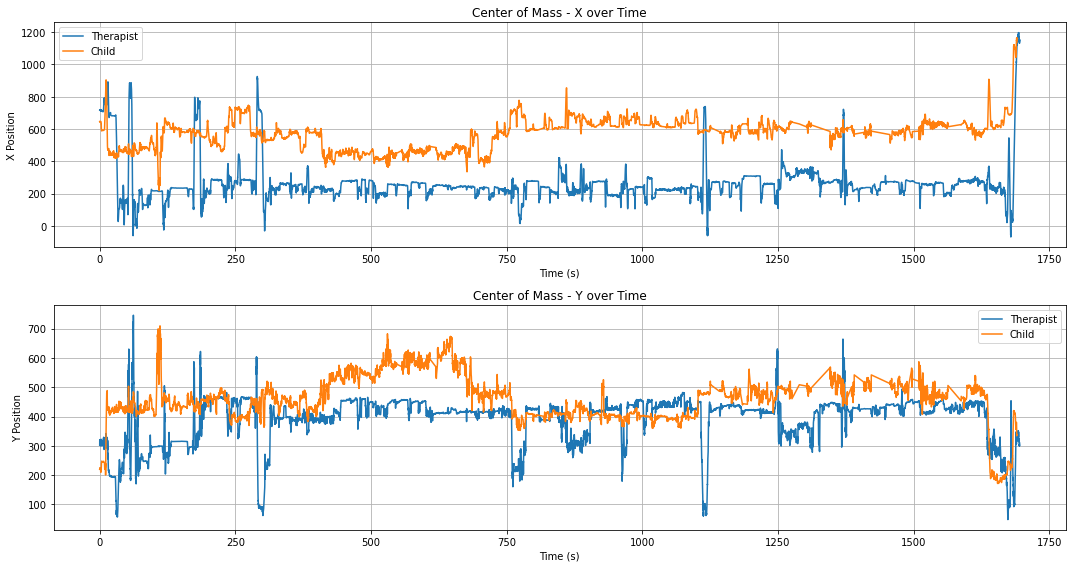

In [8]:
JOINT_NAMES_UPD = [
    "nose", "neck", "r_shoulder", "r_elbow", "r_wrist", "l_shoulder", "l_elbow", "l_wrist",
    "mid_hip", "r_hip", "r_knee", "r_ankle", "l_hip", "l_knee", "l_ankle",
    "r_eye", "l_eye", "r_ear", "l_ear", "l_big_toe", "l_small_toe", "l_heel",
    "r_big_toe", "r_small_toe", "r_heel"
    # "background" not included if already dropped
]

def compute_mass_center(df, person_label):
    """
    Compute center of mass (mean of all visible keypoints) for a person.
    """
    person_data = df[df["person_label"] == person_label].copy()
    centers = {}

    for _, row in person_data.iterrows():
        xs, ys = [], []

        for joint in JOINT_NAMES_UPD:
            x, y = row.get(f"{joint}_x"), row.get(f"{joint}_y")
            if not np.isnan(x) and not np.isnan(y):
                xs.append(x)
                ys.append(y)
        mean_x = np.mean(xs)
        mean_y = np.mean(ys)
        centers[row["time_s"]] = (mean_x, mean_y)

    return centers

def plot_mass_centers(df, id_to_label):
    """
    Plot center of mass X and Y over time for all labeled persons.
    """
    plt.figure(figsize=(15, 8))

    all_centers = {}

    # Compute mass centers only once per person
    for label in id_to_label.values():
        centers = compute_mass_center(df, label)
        if centers:
            all_centers[label] = centers

    # Plot X coordinates
    plt.subplot(2, 1, 1)
    for label, centers in all_centers.items():
        times = sorted(centers.keys())
        x_vals = [centers[t][0] for t in times]
        plt.plot(times, x_vals, label=label)
    plt.title("Center of Mass - X over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("X Position")
    plt.grid(True)
    plt.legend()

    # Plot Y coordinates
    plt.subplot(2, 1, 2)
    for label, centers in all_centers.items():
        times = sorted(centers.keys())
        y_vals = [centers[t][1] for t in times]
        plt.plot(times, y_vals, label=label)
    plt.title("Center of Mass - Y over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_mass_centers(df_processed, id_to_label)

